In [1]:
from load_data import *
import pingouin as pg
import re

testBehav = behavior.query("(session=='experiment') & (condType in @condTypes)")
usedTestSubjs = testBehav[~testBehav.excluded].subjectId.unique()
testTrials = testBehav.query('subjectId in @usedTestSubjs').set_index(['subjectId', 'trialCount'], verify_integrity=True)

(Re)loading load_data


In [2]:
pupils = samples.query("session=='experiment'").merge(testTrials, left_on=['subjectId', 'Trial'], right_index=True)
testTrials['Start'] = pupils.groupby(['subjectId', 'Trial']).Time.min() + pd.to_timedelta('2s')
testTrials['End'] = pupils.groupby(['subjectId', 'Trial']).Time.min() + pd.to_timedelta('6s')

In [3]:
def loadSaccades(file_name):
    cols = ['Event Type','Start','End', 'Amplitude']
    out = pd.read_csv(file_name, skiprows=list(range(12))+list(range(13,20)), sep='\t', usecols=cols, index_col=False)
    out = out[out['Event Type'].isin(['Saccade L', 'Saccade R'])]
    out['Start'] = pd.to_datetime(out.Start.astype(np.int64), unit='us')
    out['End'] = pd.to_datetime(out.End.astype(np.int64), unit='us')
    return out

In [4]:
%%time

maxAmplitude = 100
saccadeRateCol = []
lastSubjectId = None
for (subjectId, _), row in testTrials.iterrows():
    if subjectId != lastSubjectId:
        rawPath = 'rawdata/experiment'
        fileList = [f for f in os.listdir(rawPath) if re.match(f'subject_{subjectId}_\\d+ Events.txt', f)]
        assert len(fileList) == 1
        saccades = loadSaccades(os.path.join(rawPath, fileList[0]))
        lastSubjectId = subjectId
    count = saccades.query('(Amplitude < @maxAmplitude) & (@row.Start <= Start <= @row.End)').Start.count() / 2.
    seconds = (row.End - row.Start) / pd.to_timedelta('1s')
    saccadeRateCol.append(count / seconds)
testTrials['saccadeRate'] = saccadeRateCol
saccadeRates = testTrials.groupby(['subjectId', 'condType']).saccadeRate.mean().unstack(['condType'])

CPU times: total: 13.9 s
Wall time: 16.2 s


,W,pval,normal
condType,,,
blush,0.941475,0.001255,False
hint,0.928761,0.000278,False
normal,0.910426,0.000038,False
wink,0.902385,0.000017,False


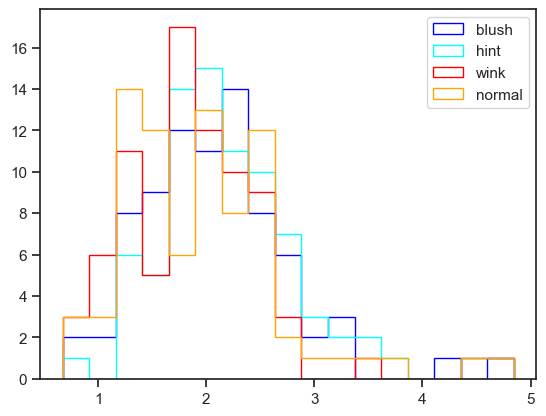

In [5]:
plt.hist(saccadeRates[condTypes], histtype='step', bins='auto', label=condTypes, color=[condColors[condType] for condType in condTypes])
plt.legend()
pg.normality(saccadeRates)

<Axes: xlabel='condType'>

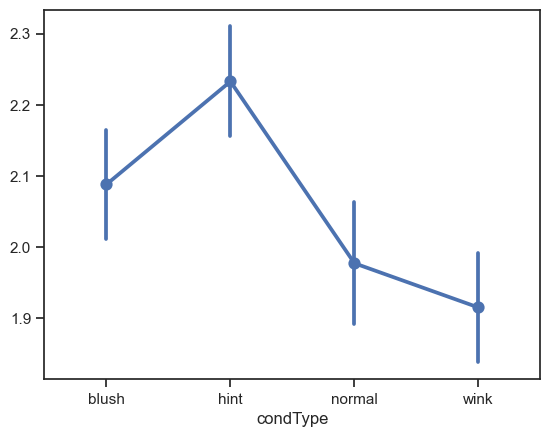

In [6]:
import seaborn as sns
sns.pointplot(saccadeRates, errorbar='se')

In [7]:
pg.friedman(saccadeRates)

,Source,W,ddof1,Q,p-unc
Friedman,Within,0.15775,3,37.386684,3.811236e-08


In [8]:
pg.wilcoxon(saccadeRates.wink, saccadeRates.normal)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,1140.0,two-sided,0.094884,-0.220779,0.477087


In [9]:
pg.wilcoxon(saccadeRates.blush, saccadeRates.hint)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,808.5,two-sided,0.000437,-0.461538,0.436388
